# THE FASHION MNIST of clothing

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

## Import the Fashion MNIST dataset

This dataset consists of four files:
```
train-images-idx3-ubyte.gz   training set images (60,000)
train-labels-idx1-ubyte.gz   training set labels (60,000)
t10k-images-idx3-ubyte.gz    test set images     (10,000)
t10k-labels-idx1-ubyte.gz    test set labels     (10,000)
```

You can manually download, load and prepare this dataset like this:
```python
from pathlib import Path
import requests
import gzip
import numpy as np

data_path = Path("data") / "FashionMNIST" / "raw"
data_path.mkdir(parents=True, exist_ok=True)

fashion_mnist_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
train_images_fn = "train-images-idx3-ubyte.gz"
train_labels_fn = "train-labels-idx1-ubyte.gz"
test_images_fn = "t10k-images-idx3-ubyte.gz"
test_labels_fn = "t10k-labels-idx1-ubyte.gz"

for filename in [train_images_fn, train_labels_fn, test_images_fn, test_labels_fn]:
    if not (data_path / filename).exists():
        content = requests.get(fashion_mnist_url + filename).content
        (data_path / filename).open("wb").write(content)

with gzip.open((data_path / train_images_fn).as_posix(), "rb") as f:
    x_train = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape((-1, 28, 28))
with gzip.open((data_path / train_labels_fn).as_posix(), "rb") as f:
    y_train = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
with gzip.open((data_path / test_images_fn).as_posix(), "rb") as f:
    x_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape((-1, 28, 28))
with gzip.open((data_path / test_labels_fn).as_posix(), "rb") as f:
    y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    
x_train, x_test = x_train / 255.0, x_test / 255.0

train_images = torch.tensor(x_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.int64)
test_images = torch.tensor(x_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.int64)

train_set = torch.utils.data.TensorDataset(train_images, train_labels)
test_set = torch.utils.data.TensorDataset(test_images, test_labels)
```

However, ``torchvision.datasets`` has a helper function, ``datasets.FashionMNIST``, that allows you to do this process easily.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])
train_set = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)

Then, you can use [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to iterate over batches of a dataset.


In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

After wrapping the training set and test set with ``DataLoader``, you can access images and labels in a ``for`` loop like this:
```python
for images, labels in train_loader:
    # do something with `images` and `labels`
```

However, the downloaded dataset can be loaded for preview. The downloaded files are stored in ``FashionMNIST/processed/`` relative to the root directory you specified above in ``datasets.FashionMNIST`` call.


In [4]:
train_images, train_labels = map(np.asarray, torch.load("./data/FashionMNIST/processed/training.pt"))
test_images, test_labels = map(np.asarray, torch.load("./data/FashionMNIST/processed/test.pt"))

Loading the dataset returns four tensor arrays:

- The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
- The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The *images* are 28x28 tensor arrays, with pixel values ranging from 0 to 255. Note that the ``tranform`` has not been applied to the ``train_images`` and ``test_images``. Images that are returned by ``train_loader`` or ``test_loader`` will be transformed. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr><th>Label</th><th>Class</th></tr>
  <tr><td>0</td><td>T-shirt/top</td></tr>
  <tr><td>1</td><td>Trouser</td></tr>
  <tr><td>2</td><td>Pullover</td></tr>
  <tr><td>3</td><td>Dress</td></tr>
  <tr><td>4</td><td>Coat</td></tr>
  <tr><td>5</td><td>Sandal</td></tr>
  <tr><td>6</td><td>Shirt</td></tr>
  <tr><td>7</td><td>Sneaker</td></tr>
  <tr><td>8</td><td>Bag</td></tr>
  <tr><td>9</td><td>Ankle boot</td></tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:


In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:


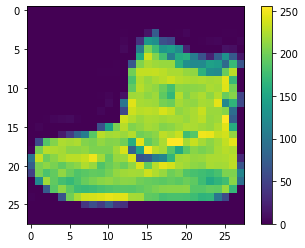

In [6]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:


In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.


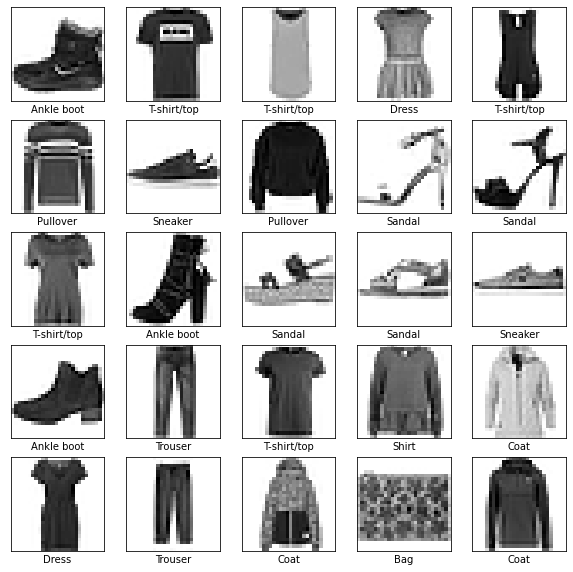

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then choosing an optimizer and a loss function.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `torch.nn.Linear`, have parameters that are learned during training.


In [9]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)
print(model)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=10, bias=True)
)


The first layer in this network, ``nn.Flatten``, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two ``nn.Linear`` layers. These are fully connected neural layers. The first ``Linear`` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes. The ``nn.Dropout`` prevents overfitting of the model by randomly removing the connections between ``Linear`` layers. It only affects the model during the training.

### Configuring the model

Before the model is ready for training, it needs a few more settings. These are used during the model's *training* step:

- *Loss function* — This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- *Optimizer* — This is how the model is updated based on the data it sees and its loss function.
- *Metrics* — This is used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def accuracy(predictions, labels):
    return np.sum(np.argmax(predictions, axis=1)==labels) / float(labels.size)
metrics = {'accuracy': accuracy}

The [``nn.CrossEntropyLoss``](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss combines [``nn.LogSoftmax()``](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) and [``nn.NLLLoss()``](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) in one single class.


## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


In [11]:
def train_epoch(model, optimizer, loss_fn, metrics, data_loader, verbose=False):
    model.train()
    mtr_sum = []
    for images, labels in data_loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        summary_batch = {metric: metrics[metric](preds.detach().numpy(), labels.detach().numpy()) 
                         for metric in metrics}
        summary_batch['loss'] = loss.item()
        mtr_sum.append(summary_batch)
    metrics_mean = {metric: np.mean([mtr[metric] for mtr in mtr_sum]) for metric in mtr_sum[0]}
    if verbose:
        metrics_string = " ; ".join("{}: {:9.6f}".format(k, v) for k, v in metrics_mean.items())
        print(metrics_string)
    return metrics_mean
    
def evaluate(model, loss_fn, metrics, data_loader, verbose=False):
    model.eval()
    mtr_sum = []
    with torch.no_grad():
        for images, labels in data_loader:
            preds = model(images)
            loss = loss_fn(preds, labels)
            summary_batch = {metric: metrics[metric](preds.detach().numpy(), labels.detach().numpy()) 
                             for metric in metrics}
            summary_batch['loss'] = loss.item()
            mtr_sum.append(summary_batch)
    metrics_mean = {metric: np.mean([mtr[metric] for mtr in mtr_sum]) for metric in mtr_sum[0]}
    if verbose:
        metrics_string = " ; ".join("{}: {:9.6f}".format(k, v) for k, v in metrics_mean.items())
        print(metrics_string)
    return metrics_mean

### Feed the model

To start training,  call the ``fit`` function—so called because it "fits" the model to the training data:


In [12]:
def fit(model, optimizer, loss_fn, metrics, data_loader, epochs=1):
    for epoch in range(epochs):
        train_metrics = train_epoch(model, optimizer, loss_fn, metrics, data_loader)
        val_metrics = evaluate(model, loss_fn, metrics, data_loader)
        train_metrics_string = " ; ".join("{}: {:9.6f}".format(k, v) for k, v in train_metrics.items())
        val_metrics_string = " ; ".join("{}: {:9.6f}".format(k, v) for k, v in val_metrics.items())
        print("Epoch {:2d} - Train -> {} - Validation -> {}".format(epoch + 1, train_metrics_string, val_metrics_string))

fit(model, optimizer, loss_fn, metrics, train_loader, epochs=10)

Epoch  1 - Train -> accuracy:  0.807050 ; loss:  0.548353 - Validation -> accuracy:  0.854667 ; loss:  0.400594
Epoch  2 - Train -> accuracy:  0.852550 ; loss:  0.406516 - Validation -> accuracy:  0.866900 ; loss:  0.357827
Epoch  3 - Train -> accuracy:  0.863933 ; loss:  0.373087 - Validation -> accuracy:  0.880433 ; loss:  0.322332
Epoch  4 - Train -> accuracy:  0.871483 ; loss:  0.352439 - Validation -> accuracy:  0.888817 ; loss:  0.303780
Epoch  5 - Train -> accuracy:  0.877800 ; loss:  0.336066 - Validation -> accuracy:  0.891833 ; loss:  0.290377
Epoch  6 - Train -> accuracy:  0.880817 ; loss:  0.321750 - Validation -> accuracy:  0.888117 ; loss:  0.297356
Epoch  7 - Train -> accuracy:  0.884800 ; loss:  0.312478 - Validation -> accuracy:  0.895467 ; loss:  0.277732
Epoch  8 - Train -> accuracy:  0.887933 ; loss:  0.303644 - Validation -> accuracy:  0.902367 ; loss:  0.261483
Epoch  9 - Train -> accuracy:  0.890067 ; loss:  0.296048 - Validation -> accuracy:  0.902283 ; loss:  0

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data. Note that both the train and validation accuracies are on training set, the former has the effect of ``Dropout`` layer and the latter without the effect of ``Dropout`` layer and after the model is trained for that epoch.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:


In [13]:
evaluate(model, loss_fn, metrics, test_loader, verbose=True)

accuracy:  0.877396 ; loss:  0.351106


{'accuracy': 0.8773961661341853, 'loss': 0.3511057247738012}

It turns out that the accuracy on the test dataset, about 88%, is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. ``Dropout`` layer reduced this gap. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data.

### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.


In [14]:
probability_model = nn.Sequential(
    model, 
    nn.Softmax(dim=1)
)

predictions = probability_model(torch.as_tensor(test_images, dtype=torch.float32)).detach().numpy()

Here, the model has predicted the label for each image in the testing set. A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:


In [15]:
print("Prediction: ", np.argmax(predictions[0]))
print("True Label: ", test_labels[0])

Prediction:  9
True Label:  9


So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct.

Graph this to look at the full set of 10 class predictions.


In [16]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100 * np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images. Let's plot several images with their predictions. Note that the model can be wrong even when very confident. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.


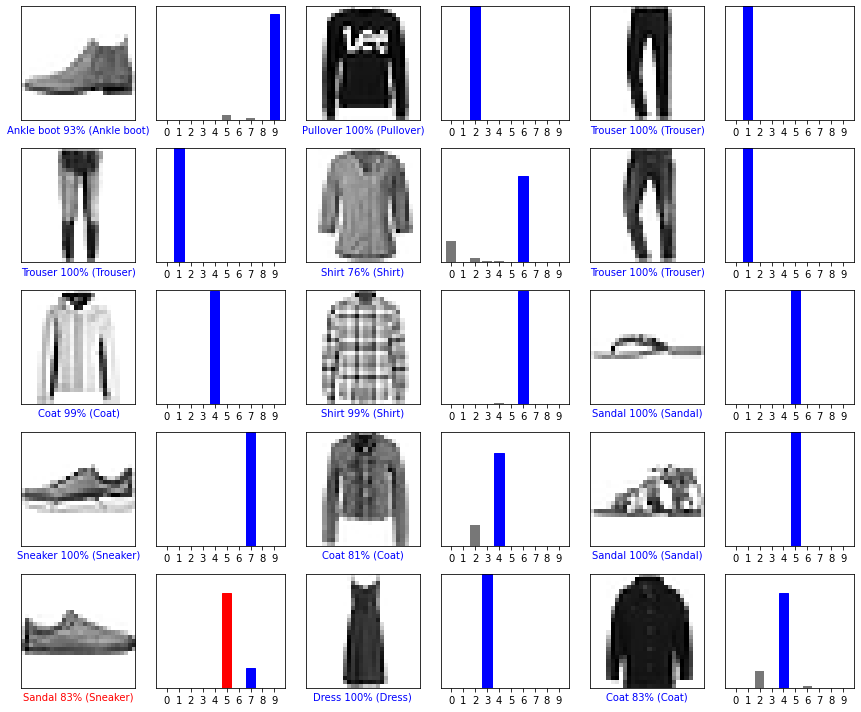

In [17]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.


In [18]:
# Grab an image from the test dataset.
img = test_images[1]
print(img.shape)

(28, 28)


``torch`` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:


In [19]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img, 0))
print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:


In [20]:
predictions_single = probability_model(torch.as_tensor(img, dtype=torch.float32)).detach().numpy()
print(predictions_single)

[[1.1994919e-05 1.2009325e-13 9.9940467e-01 2.8686753e-10 4.5997844e-04
  2.1772880e-14 1.2332939e-04 3.1529577e-24 1.7397536e-10 1.2640401e-16]]


Now plot the image with its predictions.

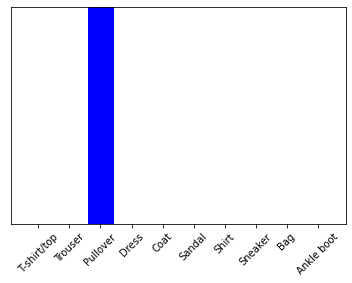

In [21]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

``probability_model`` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [22]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.


# Convolutional Neural Networks

Now, let's change our model to take advantage of convolutional neural networks. But, we need to add a channels dimension before feeding the data to [``torch.nn.Conv2d``](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).


There are two ways to build our model. ``nn.Sequential`` can be used to stack layers similar to what we did above. It will be something like this:
```python
conv_model = nn.Sequential(
    nn.Conv2d(1, 32, (3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, (3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(5 * 5 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
```

But, we build our model by subclassing ``nn.Module``:


In [23]:
class Fashion_Mnist_Conv(nn.Module):
    def __init__(self):
        super(Fashion_Mnist_Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        return self.fc2(x)

# Create an instance of the model
conv_model = Fashion_Mnist_Conv()
print(conv_model)

Fashion_Mnist_Conv(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten()
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Let's choose an optimizer, loss function, and accuracy as a metric for training of our new model.


In [24]:
conv_loss_fn = nn.CrossEntropyLoss()
conv_optimizer = optim.Adam(conv_model.parameters())
metrics = {'accuracy': accuracy}

Now we can train our model.


In [25]:
fit(conv_model, conv_optimizer, conv_loss_fn, metrics, train_loader, epochs=10)

Epoch  1 - Train -> accuracy:  0.834367 ; loss:  0.453338 - Validation -> accuracy:  0.888650 ; loss:  0.305415
Epoch  2 - Train -> accuracy:  0.891133 ; loss:  0.298396 - Validation -> accuracy:  0.890067 ; loss:  0.291612
Epoch  3 - Train -> accuracy:  0.906350 ; loss:  0.253779 - Validation -> accuracy:  0.914833 ; loss:  0.229719
Epoch  4 - Train -> accuracy:  0.917533 ; loss:  0.221060 - Validation -> accuracy:  0.920900 ; loss:  0.208005
Epoch  5 - Train -> accuracy:  0.927017 ; loss:  0.196271 - Validation -> accuracy:  0.943883 ; loss:  0.154245
Epoch  6 - Train -> accuracy:  0.935000 ; loss:  0.175372 - Validation -> accuracy:  0.945900 ; loss:  0.144674
Epoch  7 - Train -> accuracy:  0.941650 ; loss:  0.157197 - Validation -> accuracy:  0.953600 ; loss:  0.129210
Epoch  8 - Train -> accuracy:  0.947133 ; loss:  0.140323 - Validation -> accuracy:  0.956917 ; loss:  0.116655
Epoch  9 - Train -> accuracy:  0.954033 ; loss:  0.122208 - Validation -> accuracy:  0.965117 ; loss:  0

Now that our model is trained, we can evaluate its performance on the test set.


In [26]:
evaluate(conv_model, conv_loss_fn, metrics, test_loader)

{'accuracy': 0.9085463258785943, 'loss': 0.28638165053753806}

The image classifier is now trained to ~91% accuracy on this dataset.
